In [1]:
# data processing
import pandas as pd
import numpy as np

# modelling
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Reshape, Conv2D, MaxPooling2D, UpSampling2D, Dense, Conv2DTranspose, Input, Flatten, Layer, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import binary_accuracy, Mean
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import mae, binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity

# visualization
import matplotlib.pyplot as plt
import seaborn as sn

# misc
import random as rn

Dataset split: 60000 train rows 60000 test rows


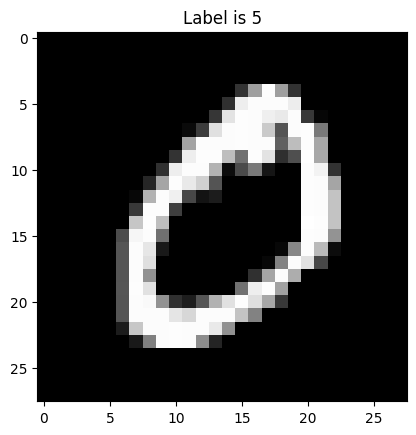

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(f"Dataset split: {len(x_train.data)} train rows",
          f"{len(y_train.data)} test rows")

point = np.array(x_train[0], dtype='float')
point = point.reshape((28, 28))
plt.title('Label is {label}'.format(label=y_train[0]))
plt.imshow(x_train[1], cmap='gray')
plt.show()

In [3]:
# normalize data
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

labels = len(np.unique(y_train))

y_train_categorical = to_categorical(y_train, num_classes=labels)
y_test_categorical = to_categorical(y_test, num_classes=labels)

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

In [24]:
codings_size = 30

generator = Sequential([
    Dense(100, activation="relu", input_shape=[codings_size]),
    Dense(150, activation="relu"),
    Dense(28 * 28, activation="sigmoid"),
    Reshape([28, 28])
])

In [25]:
discriminator = Sequential([
    Flatten(input_shape=[28, 28]),
    Dense(150, activation="relu"),
    Dense(100, activation="relu"),
    Dense(1, activation="sigmoid")
])

In [26]:
gan = Sequential([generator, discriminator])

In [27]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [28]:
print("Training data shape: ", x_train.shape)
print("Training labels shape: ", y_train.shape)
print("Test data shape: ", x_test.shape)
print("Test labels shape: ", y_test.shape)

Training data shape:  (60000, 28, 28)
Training labels shape:  (60000,)
Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)


In [30]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [31]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [32]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()   

Epoch 1/12


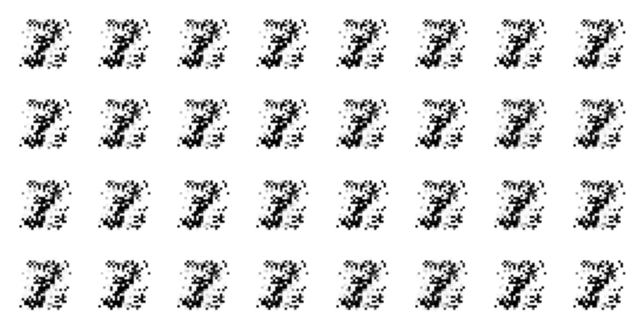

Epoch 2/12


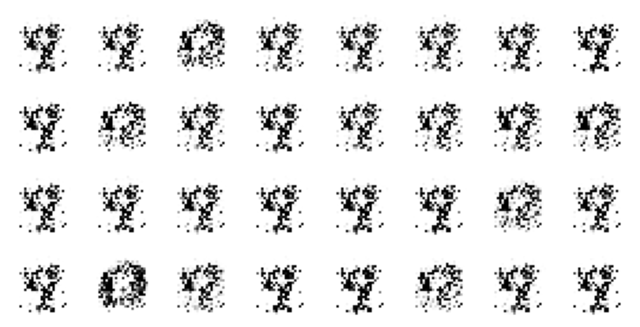

Epoch 3/12


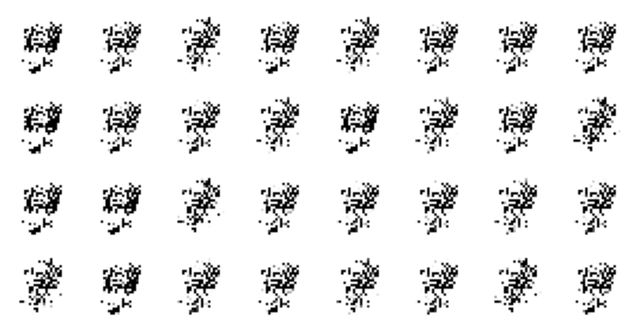

Epoch 4/12


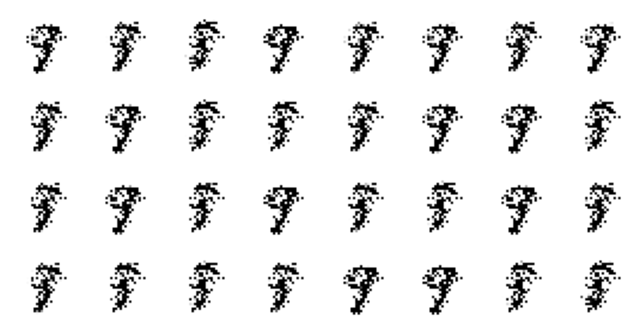

Epoch 5/12


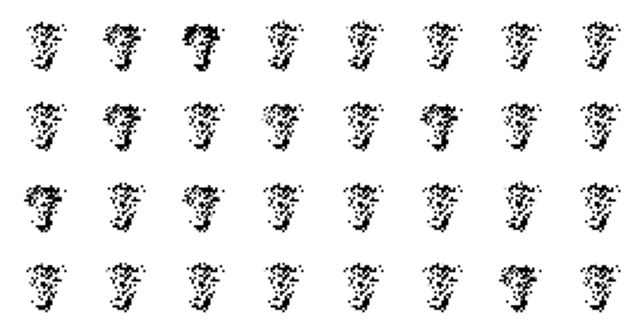

Epoch 6/12


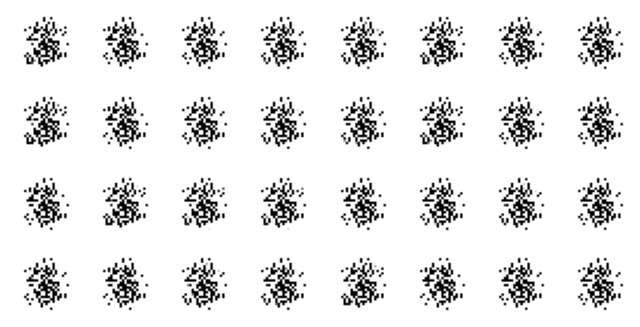

Epoch 7/12


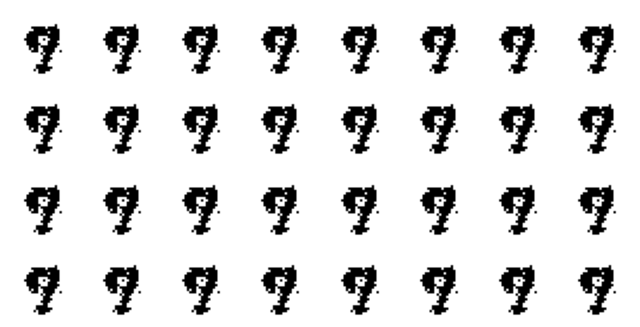

Epoch 8/12


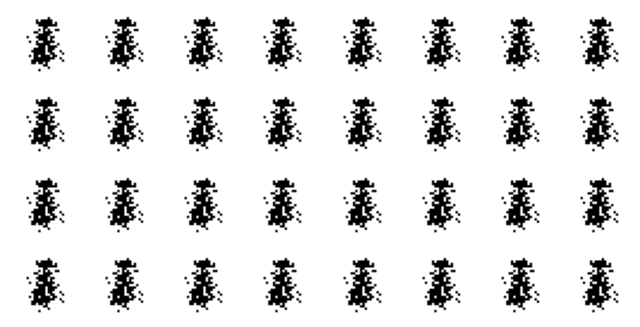

Epoch 9/12


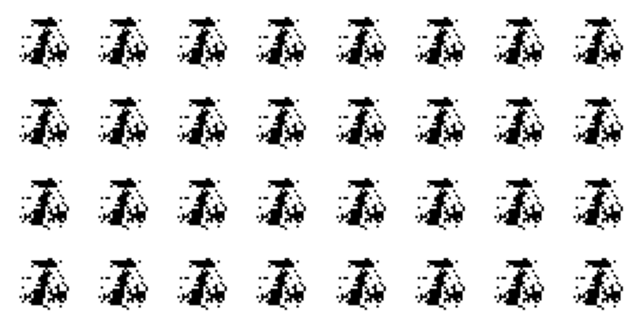

Epoch 10/12


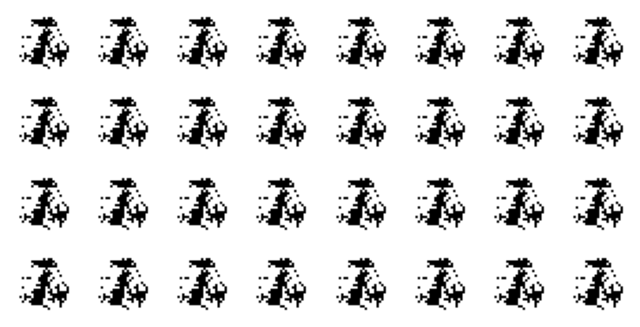

Epoch 11/12


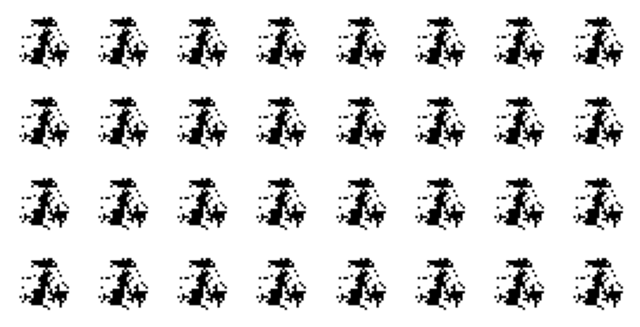

Epoch 12/12


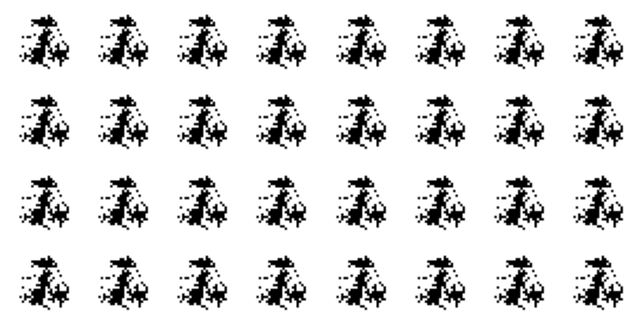

In [33]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=12)